In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

# Load tickers and their descriptions from the Excel file
ticker_details = pd.read_excel("/Users/nischith/Desktop/Ticker List.xlsx")
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

In [5]:
# Set the date range for the data
end_date = "2024-10-01"
start_date = "2000-01-01"
date_range = pd.bdate_range(start=start_date, end=end_date)

values = pd.DataFrame({'Date': date_range})
values['Date'] = pd.to_datetime(values['Date'])

In [7]:
# Loop through each ticker and fetch historical data
for i in ticker:
    print(f"Fetching data for: {i}")
    
    # Fetch the raw data using YahooFinancials
    raw_data = YahooFinancials(i)
    try:
        raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
        
        # Check if raw_data is None or if 'prices' key is not present
        if raw_data is None:
            print(f"Data for {i} is None. Skipping this ticker.")
            continue
        if i not in raw_data:
            print(f"Ticker {i} not found in Yahoo Finance data. Skipping this ticker.")
            continue
        if 'prices' not in raw_data[i]:
            print(f"No 'prices' data found for {i}. Skipping this ticker.")
            continue

        # Extract 'prices' from the raw data and create a DataFrame
        df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date', 'adjclose']]
        df.columns = ['Date1', i]  # Rename columns to 'Date1' and ticker
        df['Date1'] = pd.to_datetime(df['Date1'])  # Ensure 'Date1' is a datetime column

        # Merge the data with the main 'values' DataFrame
        values = values.merge(df, how='left', left_on='Date', right_on='Date1')
        values = values.drop(labels='Date1', axis=1)  # Drop the temporary 'Date1' column
    
    except Exception as e:
        print(f"An error occurred for {i}: {e}")
        continue 


Fetching data for: GC=F
Fetching data for: SI=F
Fetching data for: CL=F
Fetching data for: ^GSPC
Fetching data for: ^RUT
Fetching data for: ZN=F
Fetching data for: ZT=F
Fetching data for: PL=F
Fetching data for: HG=F
Fetching data for: DX=F
Fetching data for: ^VIX
Fetching data for: S=F
An error occurred for S=F: argument of type 'NoneType' is not iterable
Fetching data for: EEM
Fetching data for: EURUSD=X
Fetching data for: ^N100
Fetching data for: ^IXIC


In [8]:
# Ensure that the 'names' list matches the number of columns in the 'values' DataFrame
names.insert(0, 'Date')

# Check if the length of 'names' matches the number of columns in 'values'
if len(names) != values.shape[1]:
    print(f"Warning: Column mismatch. Expected {len(names)} but found {values.shape[1]} columns.")
    # Align the 'names' list by truncating or extending it to match the columns in 'values'
    names = names[:values.shape[1]] 

# Assign the correct column names to the 'values' DataFrame
values.columns = names

# Check for missing values and print the data shape and count of missing values
print(f"Shape of final data: {values.shape}")
print(f"Missing values count:\n{values.isna().sum()}")




Shape of final data: (6457, 16)
Missing values count:
Date                          0
Gold                        415
Silver                      413
Crude Oil                   406
S&P500                      232
Russel 2000 Index           232
10 Yr US T-Note futures     425
2 Yr US T-Note Futures      359
Platinum                    931
Copper                      410
Dollar Index                327
Volatility Index            232
Soybean                    1054
MSCI EM ETF                1684
Euro USD                    128
Euronext100                 232
dtype: int64


In [9]:
# Front filling and back filling NaN values in the dataset
values = values.fillna(method="ffill", axis=0)
values = values.fillna(method="bfill", axis=0)
values.isna().sum()



/var/folders/s8/_qp51q0x7fd09rb_jcw9n09c0000gn/T/ipykernel_38968/2665983716.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  values = values.fillna(method="ffill", axis=0)
/var/folders/s8/_qp51q0x7fd09rb_jcw9n09c0000gn/T/ipykernel_38968/2665983716.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  values = values.fillna(method="bfill", axis=0)


Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
dtype: int64

In [ ]:
# Display the last few rows to verify the data
print(values.tail())

In [57]:
#Coerce numeric type to all columns except Date
cols = values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric, errors='coerce').round(decimals=1)
values.tail()

In [59]:
# Save the processed data to CSV
values.to_csv("/Users/nischith/Desktop/Data.csv")

In [62]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [64]:
# Load the dataset
file_path = '/Users/nischith/Desktop/Data.csv'
data = pd.read_csv(file_path)

In [66]:
# Clean data by dropping unnecessary columns and filling missing values
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [68]:
# Fill missing values in the dataset
for col in data.columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)

In [70]:
# Split the data into features (X) and target (y)
X = data.drop(columns=['Gold'])
y = data['Gold']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Define models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "Support Vector Regressor": SVR()
}

In [74]:
# Dictionary to store results
results = {
    "Model": [],
    "R^2 Score": [],
    "Mean Absolute Error (MAE)": [],
    "Mean Squared Error (MSE)": []
}

In [76]:
# Train models, evaluate and store results
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    results["Model"].append(model_name)
    results["R^2 Score"].append(r2)
    results["Mean Absolute Error (MAE)"].append(mae)
    results["Mean Squared Error (MSE)"].append(mse)

In [77]:
# Convert results to DataFrame and sort by R^2 Score
results_df = pd.DataFrame(results)
results_df.sort_values(by="R^2 Score", ascending=False, inplace=True)

# Print the evaluation results
print(results_df)

                         Model  R^2 Score  Mean Absolute Error (MAE)  \
2      Random Forest Regressor   0.999539                   7.532986   
1      Decision Tree Regressor   0.999042                   9.984907   
3  Gradient Boosting Regressor   0.997202                  20.978509   
0            Linear Regression   0.981474                  59.735370   
4     Support Vector Regressor   0.545926                 305.426118   

   Mean Squared Error (MSE)  
2                152.638382  
1                317.376215  
3                927.170851  
0               6139.595233  
4             150478.071023  


In [80]:
# Identify the best model (highest R^2 score)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

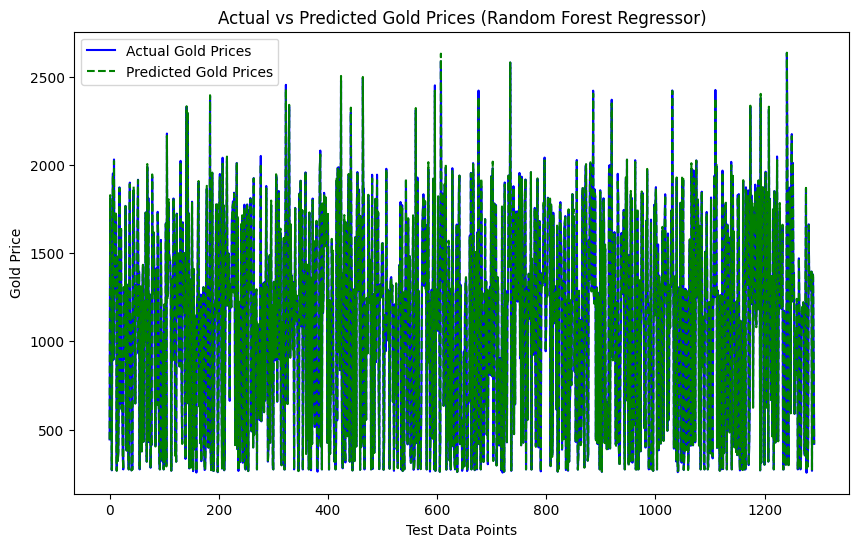

In [82]:
# Plot actual vs predicted gold prices for the best model
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Gold Prices', color='b')
plt.plot(y_pred_best, label='Predicted Gold Prices', color='g', linestyle='--')
plt.title(f"Actual vs Predicted Gold Prices ({best_model_name})")
plt.xlabel("Test Data Points")
plt.ylabel("Gold Price")
plt.legend()
plt.show()

In [84]:
# Function to predict Gold price based on new input, including the date in input_data
def predict_gold_price(input_data):
    input_data['Date'] = pd.to_datetime(input_data['Date'])
    input_df = pd.DataFrame([input_data])
    predicted_gold_price = best_model.predict(input_df.drop(columns=['Date']))[0]
    return predicted_gold_price

In [92]:
# Example of using the function to predict for a specific date and input data (including date inside the dictionary)
input_data = {
    'Date': '2000-10-02',  # Date format 'YYYY-MM-DD'
    'Silver': 31.2,
    'Crude Oil': 68.2,
    'S&P500': 5762.5,
    'Russel 2000 Index': 2230.0,
    '10 Yr US T-Note futures': 114.3,
    '2 Yr US T-Note Futures': 104.0,
    'Platinum': 979.0,
    'Copper': 4.5,
    'Dollar Index': 100.5,
    'Volatility Index': 16.7,
    'Soybean': 45.9,
    'MSCI EM ETF': 1.1,
    'Euro USD': 1484.7,
    'Euronext100': 18189.2
}


predicted_price = predict_gold_price(input_data)
print(f"Predicted Gold Price on {input_data['Date']}: {predicted_price}")

Predicted Gold Price on 2000-10-02 00:00:00: 2636.871000000002
